Let's import the needed libraries.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

Let's define our probability function

In [3]:
A = 8.8480182 
def f(x):
    if x < -3 or x > 3:
        return 0
    return (1/A) * (x**2) * (np.sin(np.pi*x)**2)

max_point = 0.717705 #empirical computed by computing the derivative
print("Function max point:", max_point)

Function max point: 0.717705


# Part 1 - sampling points with rejection sampling
We have followed the rejection methods for continuous distributions, setting a constant $c$ such that:
$\frac{f(y)}{g(y)} \leq c \text{ } \forall y$

Our function $g$ is $g(x) = 1$, a natural choice due to the simplicity of sampling from it.


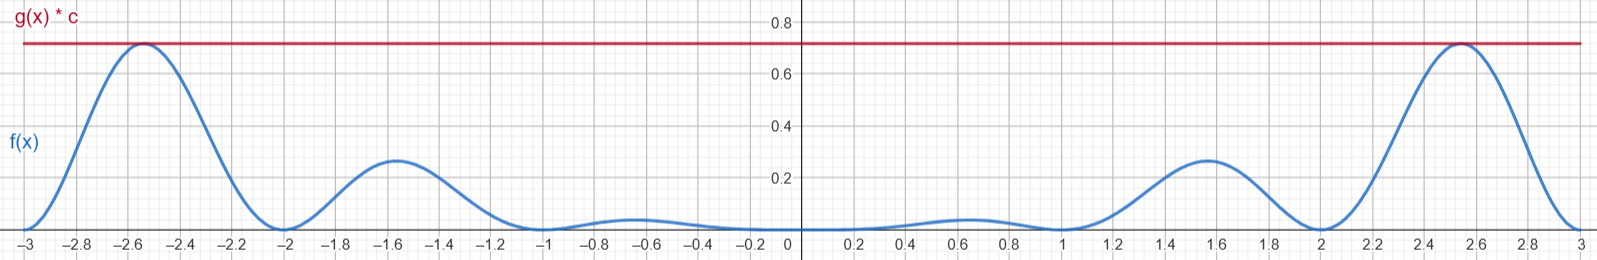

In [4]:
samples = []
N = 300_000
fails = 0

def g(x):
    if x < -3 or x > 3:
        return 0
    return 1

c = max_point #c is the constant that we need to satisfy the condition of the rejection method

"""
Note that this is just one of the possible values of c satisfying the condition, choosing a different one, less "closer" to the distribution,
we would have more rejections.
"""

for i in range(N):
    U1, U2 = random.uniform(-3, 3), random.uniform(0, 1) #we generate U1 according to g(x) and U2 according to uniform distribution in [0,1]

    while U2 > (f(U1) / (g(U1) * c)):                   #we verify if we can accept U1 or we have to reject it
        fails+=1
        U1, U2 = random.uniform(-3, 3), random.uniform(0, 1)
    samples.append(U1)

print(f"To sample {N} points, we had to reject {fails} points.")

To sample 300000 points, we had to reject 989791 points.


## Is the value of A mandatory?

The value of $A$ is not mandatory for performing rejection sampling since our process does not rely on the absolute scale of $f(x)$. Our constant $c$ is used to ensure I am sampling from a distribution $g(x)$ and what I am getting is "above" the pdf.

However by knowing A we can significally improve the efficiency of the algorithm, since we can accurately compute the maximum value of $f(x)$ reducing the number of points to draw for a valid sample.

# PART 2 - plotting the results

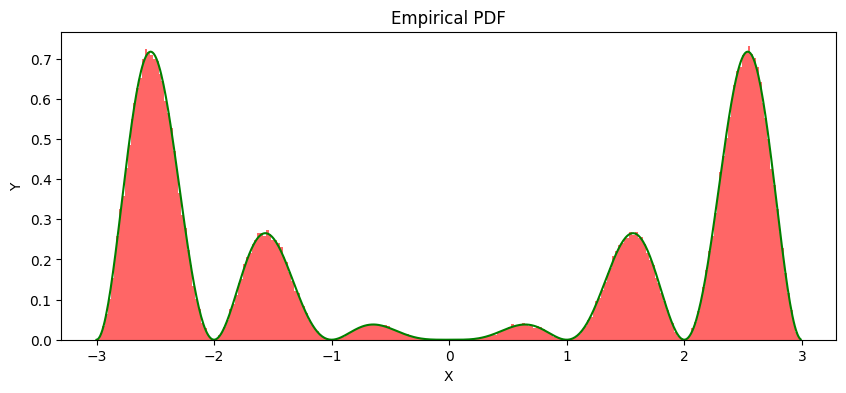

In [5]:
BINS = 250

x_points = np.arange(-3, 3, 0.01)
y_points = list(map(f, x_points))

plt.figure(figsize=(10, 4))
plt.title('Empirical PDF')
plt.hist(samples, bins=BINS, density=True, alpha=0.6, color='red')
plt.plot(x_points, y_points, color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# PART 3 - confidence intervals computation

First of all define some utility functions and parameters of our simulation.

In [30]:
#Let's use this sampling function, exactly the same as before but rearranged differently
def sampling_procedure(N):
    
    for i in range(N):
        U1 = random.uniform(-3, 3)
        U2 = random.uniform(0, max_point)
    
        while U2 >= f(U1):
            U1 = random.uniform(-3, 3)
            U2 = random.uniform(0, max_point)
    
        samples.append(U1)
    
    return samples

In [31]:
#Samples some datapoints and consider top 200
N = 20_000
n = 200
samples = sampling_procedure(N)

First of all we compute the confidence intervals for the median (0.5-quantile) and the 0.9-quantile using the standard procedure for large dataset, as illustrated in slide 24 of the set of slide 05.

We can apply this procedure since the IID assumption is verified and we have a quite large dataset (n = 200).

Additionally, we can estimate a confidence interval for the mean following the asymptotic case, thanks to the fact we have a large dataset and a not wild distributions, meaning we have not so many outliers.
This allows us to apply the central limit theorem and assume our draws come from a normal distribution.

In [32]:
print("\t\t", "Regular procedure for large datasets\n")

confidence = 0.95
etha = 1.96

#CI for median
p = 0.5
j = np.floor(n*p-etha*np.sqrt(n*p*(1-p)))
k = np.ceil(n*p+etha*np.sqrt(n*p*(1-p))) + 1
sorted_n = samples[0:n]
sorted_n.sort()
print("Median: ")
print("\t", sorted_n[int(j)], sorted_n[int(k)])

#CI for 0.9 quantile
p = 0.9
j = np.floor(n*p-etha*np.sqrt(n*p*(1-p)))
k = np.ceil(n*p+etha*np.sqrt(n*p*(1-p))) + 1
sorted_n = samples[0:n]
sorted_n.sort()
print("0.9 quantile: ")
print("\t", sorted_n[int(j)], sorted_n[int(k)])

#CI for mean
first_n = samples[0:n]
empirical_mean = sum(first_n) / n
empirical_variance = sum([(x - empirical_mean)**2 for x in first_n]) / n
print("Mean: ")
delta = etha * (np.sqrt(empirical_variance / n))
print("\t", empirical_mean - delta, empirical_mean + delta)

		 Regular procedure for large datasets

Median: 
	 -1.6873131257203273 1.3944265923139323
0.9 quantile: 
	 2.550397303000623 2.775309267287968
Mean: 
	 -0.5121701166131479 0.12531722754923236


## Computing CIs using Bootstrap procedure

The Bootstrap Percentile Method is another procedure we can use to compute confidence interval for any statistical metrics.

It is very simple because it only requires data IID but is still, as we can see, robust.

In [33]:
print("\t\t", "Bootstrap Percentile Method\n")
R, j, k = 999, 25, 975 #standard for confidence = 0.95

first_n = samples[0:n] 
bootstrap_sample = []
medians = []
means = []
percentiles_90 = []

for i in range(R):

    bootstrap_sample = []
    
    for j in range(n):
        bootstrap_sample.append(random.choice(first_n)) #implements sampling with replacement
    
    bootstrap_sample.sort()
    medians.append(0.5*(bootstrap_sample[int(np.floor(n/2))]+bootstrap_sample[int(np.floor(n/2))+1]))
    k1 = np.floor(n*0.9+0.1)
    k2 = np.ceil(n*0.9+0.1)
    percentiles_90.append(0.5*(bootstrap_sample[int(k1)]+bootstrap_sample[int(k2)]))
    means.append(sum(bootstrap_sample) / n)

medians.sort()
means.sort()
percentiles_90.sort()
print("Median: ")
print("\t", medians[j], medians[k])
print("0.9 quantile: ")
print("\t", percentiles_90[j], percentiles_90[k])
print("Mean: ")
print("\t", means[j], means[k])

		 Bootstrap Percentile Method

Median: 
	 -1.5176377843980784 1.3704399495144397
0.9 quantile: 
	 2.5964688977144403 2.726785821755576
Mean: 
	 -0.3341471925598134 0.11783368227065845


# PART 4 - Multiple CIs computation

Now we are computing multiple CI for the previous metrics, using the asymptotic procedures.

Since our confidence level is set at 95%, we are showing that the 5% of the CI will not contain the true mean.

In [34]:
true_mean = 0.0 #this is the true mean of the distribution
#we expect it is contained in 95 out of 100 intervals

sets = 100
partition = []

for j in range(sets):
    random.shuffle(samples) #superfluo - useless (since they are iid)
    partition.append(samples[0:n]) #it chooses first n elements from samples
    samples = samples[n:] #it removes first n elements from samples

#CI for mean - using asymptotic case: we have no heavy tail
confidence = 0.95
etha = 1.96

conf_inters = []

for i in range(sets):
    empirical_mean = sum(partition[i]) / n
    empirical_variance = sum([(x - empirical_mean)**2 for x in partition[i]]) / n
    delta = etha * (np.sqrt(empirical_variance / n))

    conf_inters.append((empirical_mean - delta, empirical_mean + delta))

print("We are done")

We are done


Let's plot the confidence intervals

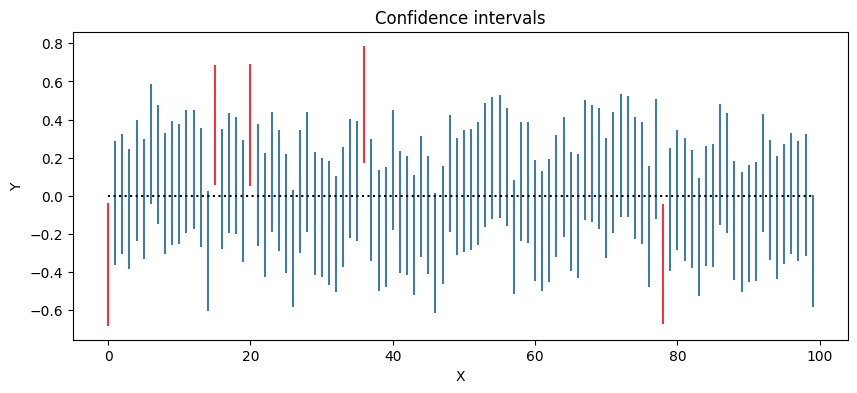

In [35]:
red = '#e63946'
blue = '#457b9d'
plt.figure(figsize=(10, 4))
plt.title('Confidence intervals')
for i in range(sets):
    a = conf_inters[i][0]
    b = conf_inters[i][1]
    plt.vlines(i, a, b, color=(blue if (true_mean >= a and true_mean <= b) else red))
plt.plot(np.arange(sets), [true_mean for x in range(sets)], ls="dotted", color='black', label='Mean')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Here we show that a possible estimation of the mean falls in more or less the 95% of the CIs (so just 5 intervals - on average - will not contain the mean).

Then answer to the question is: 5% so 5 CIs will be wrong (since we have designed our experiment to be in a way that my CI will contain the mean 95% of the time).
